In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from folder import StandardFolder
from polars_utils import *

# OUTPUTS
FOLDER_OUT = Path("D:/Prut/Warehouses/output/Jun24/n/dementia")

# INPUTS
# Cases in our other cohorts
FOLDER_OC = StandardFolder("H:/Shared drives/Datalake/Data/20240630_fu")
# Cases not in any cohorts, i.e. new cases
FOLDER_NC = StandardFolder("H:/Shared drives/Datalake/Loosely_criteria_data/newcase_202406(Jan-June2024)/Data for new case iden 202406")
# Dementia standard values
DEMENTIA_STANDARD = "D:/Prut/Warehouses/std/Dementia_DX_PS.xlsx"
dementia_icd: list = pd.read_excel(DEMENTIA_STANDARD, 0)['ICD10'].tolist()
dementia_drugcodes: list = pd.read_excel(DEMENTIA_STANDARD, 1)['drug_code'].tolist()
dementia_icd_re: str = '^' + '|^'.join(dementia_icd)
dementia_drugcodes_re: str = '|'.join(dementia_drugcodes)

print(dementia_icd_re)
print(dementia_drugcodes_re)

er_emr not included.
summary_discharge not included.
dimension table not included.
^F000|^F001|^F002|^F009|^G300|^G301|^G308|^G309|^F010|^F011|^F012|^F013|^F018|^F019|^G310|^F020|^G3183|^F023|^G232|^G233|^G231
ARIP-T-|ARIP1T-|ARIT-T-|DONC-T-|DOND-T-|DOND1T-|DONT-T-|DONZ-T-|EBIX-S-|EBIX-T-|EBIX1T-|EBXA-S-|ELAP-S-|EXEL-S-|EXEL-S1|EXEL1C-|EXEL1X-|EXEL2C-|EXEL2X-|EXEL3C-|EXEL3X-|EXEL4C-|EXEL5C-|MEMA-T-|MEME-T-|REMN1T-|REMN2T-|REMN3C-|REMN4C-


In [2]:
def get_dx(paths: list[Path], re: str, streaming: bool=False):
    to_concat = []
    # Loop through all files
    for path in paths:
        # Scan and parse dates
        file = (
            scan_file(path)
            .select(pl.col(['ENC_HN', 'D001KEY', 'D035KEY']))
        )
        file = parse_dates(file, 'D001KEY', format="%Y%m%d")
        # Select desired ICD10 codes
        file = file.filter(pl.col('D035KEY').str.contains(re))
        # One day per row
        file = file.group_by(pl.col(['ENC_HN', 'D001KEY'])).agg(pl.col('D035KEY')).with_columns(pl.col('D035KEY').list.unique().list.sort().list.join(', '))
        file = file.collect(streaming=streaming)
        to_concat.append(file)
    return pl.concat(to_concat).unique()


def get_drug(paths: list[Path], re: str, streaming: bool=False):

    to_concat = []
    for path in paths:
        file = scan_file(path)
        # Deal with alternative file structures
        if {'PER_DATE_2', 'SERVICE_ID', 'CAL_SER_AMT'}.issubset(file.columns):
            file = file.rename({'PER_DATE_2': 'D001KEY', 'SERVICE_ID': 'D033KEY', 'CAL_SER_AMT': 'M1022'})
        file = file.select(pl.col(['ENC_HN', 'D001KEY', 'D033KEY', 'M1022']))

        file = parse_dates(file, 'D001KEY', format="%Y%m%d")

        file = file.filter(pl.col('D033KEY').str.contains(re))

        to_concat.append(file.collect(streaming=streaming))

    return pl.concat(to_concat)

In [3]:
med_paths = list(FOLDER_OC.bill.iterdir()) + list(FOLDER_NC.meds.iterdir()) # Some bills some meds, must manually check
med_paths = med_paths[::-1] # remove [:n]

In [4]:
med = get_drug(med_paths, dementia_drugcodes_re, streaming=True)
med

ENC_HN,D001KEY,D033KEY,M1022
str,date,str,str
"""A434FAA313ACDC…",2024-03-21,"""DOND-T-""","""63"""
"""14C3ED7D22CF93…",2024-03-12,"""DOND-T-""","""67.05263157894…"
"""14C3ED7D22CF93…",2024-03-12,"""DOND-T-""","""23.94736842105…"
"""4E337FACB0A17F…",2024-03-25,"""DOND-T-""","""82.52631578947…"
"""1B3757D7B6ABFD…",2024-03-19,"""DOND-T-""","""47.89473684210…"
"""1B3757D7B6ABFD…",2024-03-19,"""DOND-T-""","""134.1052631578…"
"""C5BD973290120F…",2024-03-19,"""DOND-T-""","""91"""
"""BFF8D4D64D528D…",2024-03-28,"""DOND-T-""","""9.210526315789…"
"""BFF8D4D64D528D…",2024-03-18,"""DOND-T-""","""0.736842105263…"


In [5]:
med['ENC_HN'].n_unique()

9131

<Axes: title={'center': 'Dementia drug codes Jan 2010 to Jun 2024'}, xlabel='Drug code', ylabel='Count'>

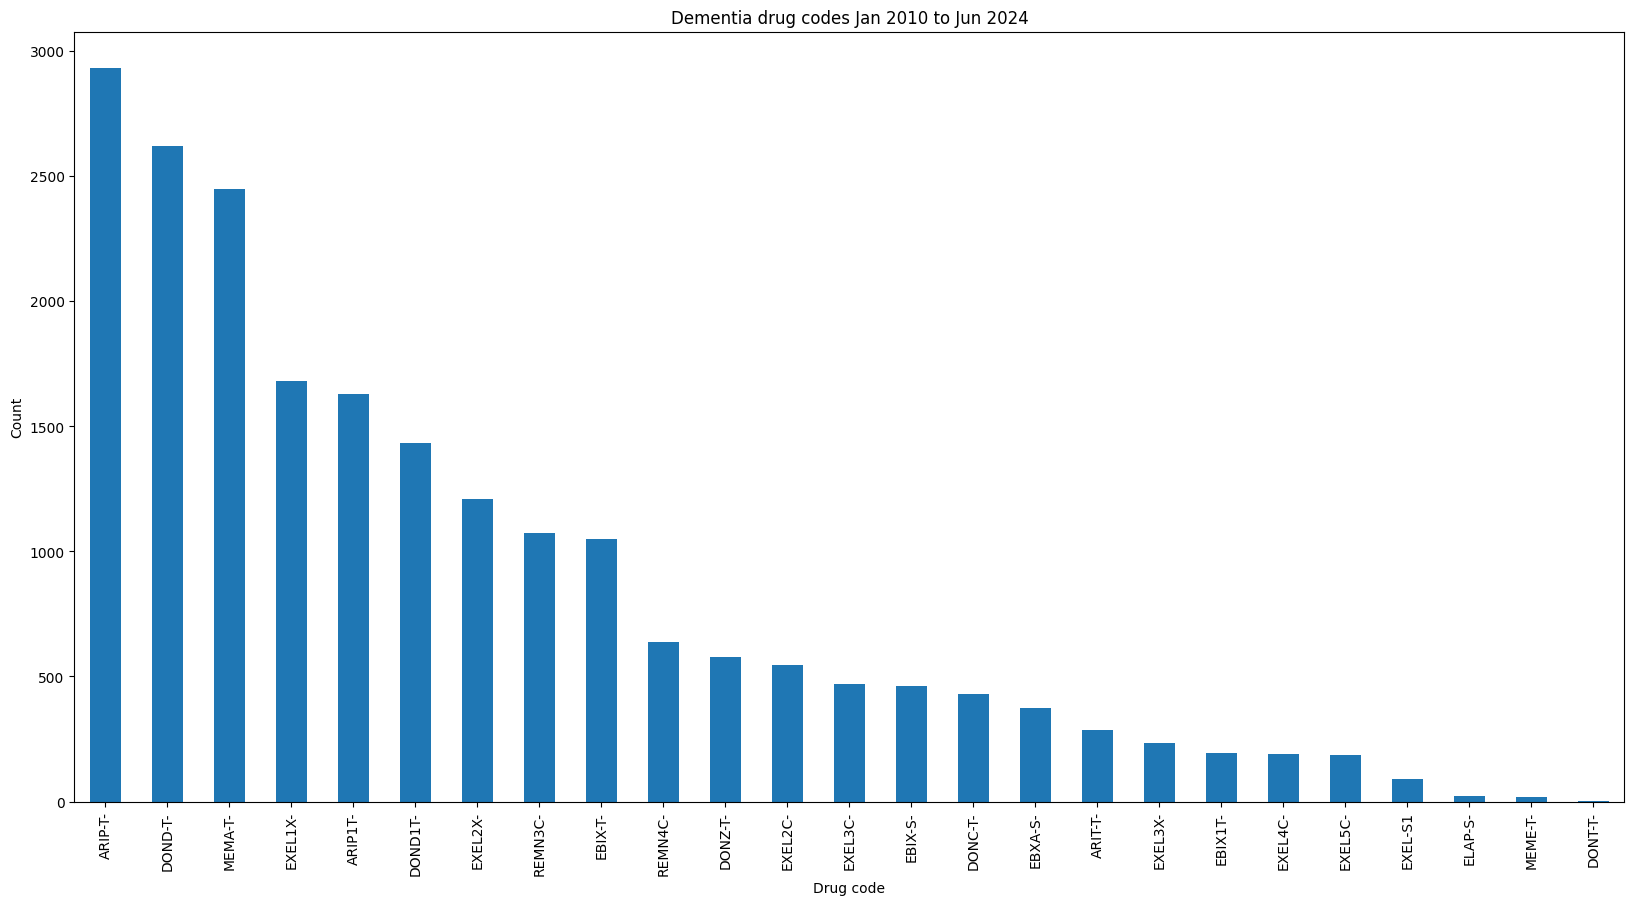

In [6]:
med.select('ENC_HN', 'D033KEY').unique().to_pandas()['D033KEY'].value_counts().plot(kind='bar', figsize=(20, 10), title='Dementia drug codes Jan 2010 to Jun 2024', xlabel='Drug code', ylabel='Count')

In [7]:
std_ = pd.read_excel(DEMENTIA_STANDARD, 1)
std_dict = dict(zip(std_['drug_code'], std_['drug_name']))

In [8]:
std_cnt = med.select('ENC_HN', 'D033KEY').unique().to_pandas()['D033KEY'].map(std_dict).value_counts()
std_cnt

D033KEY
Donepezil               9913
Memantine HCl           4547
Rivastigmine Base       3124
Galantamine             1710
Rivastigmine Tartate    1508
Name: count, dtype: int64

<Axes: title={'center': 'Dementia drugs from Jan 2010 to Jun 2024'}, xlabel='Drug name', ylabel='Count'>

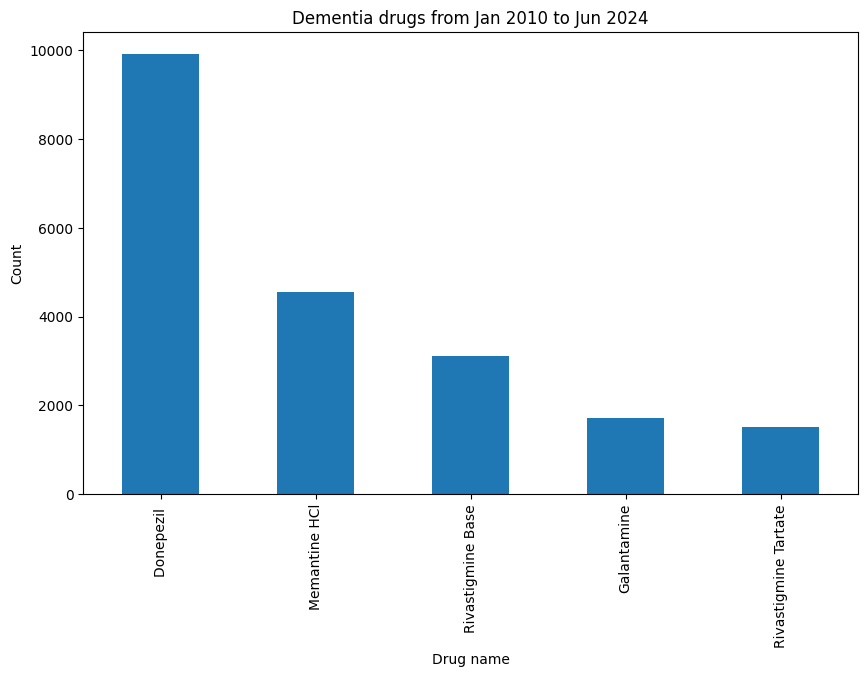

In [9]:
std_cnt.plot(kind='bar', figsize=(10, 6), title='Dementia drugs from Jan 2010 to Jun 2024', xlabel='Drug name', ylabel='Count')

In [10]:
dx_paths = list(FOLDER_OC.dx.iterdir()) + list(FOLDER_NC.dx.iterdir())

dx = get_dx(dx_paths, re=dementia_icd_re, streaming=False)
dx

ENC_HN,D001KEY,D035KEY
str,date,str
"""F064328096AB54…",2014-05-24,"""G231"""
"""486B18602FAC5D…",2014-11-01,"""F0194"""
"""3AA31513A4291E…",2014-01-22,"""F0090, G309"""
"""C890FCA1D120B7…",2014-02-08,"""G309"""
"""1B51E6F150E743…",2014-05-26,"""G309"""
"""F3E97BF5B78CB4…",2014-09-11,"""F0014, F0234, …"
"""942C5FDF5AE012…",2014-12-25,"""F0101"""
"""84A7E0503EF22C…",2014-05-20,"""G309"""
"""FF16861F21960D…",2014-11-12,"""F0190"""


In [11]:
dx['ENC_HN'].n_unique()

7861

In [14]:
def get_dx_viz(paths: list[Path], re: str, streaming: bool=False):
    to_concat = []
    # Loop through all files
    for path in paths:
        # Scan and parse dates
        file = (
            scan_file(path)
            .select(pl.col(['ENC_HN', 'D001KEY', 'D035KEY']))
        )
        file = parse_dates(file, 'D001KEY', format="%Y%m%d")
        # Select desired ICD10 codes
        file = file.filter(pl.col('D035KEY').str.contains(re))
        file = file.with_columns(pl.col('D035KEY').str.slice(0, 4).str.replace('G318', 'G3183'))
        # One day per row
        # file = file.group_by(pl.col(['ENC_HN', 'D001KEY'])).agg(pl.col('D035KEY')).with_columns(pl.col('D035KEY').list.unique().list.sort().list.join(', '))
        file = file.collect(streaming=streaming)
        to_concat.append(file)
    return pl.concat(to_concat).unique()

dx_viz = get_dx_viz(dx_paths, re=dementia_icd_re, streaming=False)
dx_viz

ENC_HN,D001KEY,D035KEY
str,date,str
"""17D120FD52FE30…",2014-12-02,"""G309"""
"""11C08A559365F0…",2014-10-01,"""G308"""
"""57EAA1C6C7C4C8…",2014-09-17,"""G301"""
"""937E2D7B7E8038…",2014-09-30,"""G309"""
"""5E74FFF8FB4DC1…",2014-05-26,"""F010"""
"""3C9E71F21C633B…",2014-10-16,"""F019"""
"""E1556DE3DDD471…",2014-01-06,"""G309"""
"""EC524DDA4ACB16…",2014-11-19,"""F019"""
"""7F4B75156D4A4B…",2014-09-03,"""G309"""


<Axes: title={'center': 'Dementia ICD10 codes Jan 2010 to Jun 2024'}, xlabel='ICD10 code', ylabel='Count'>

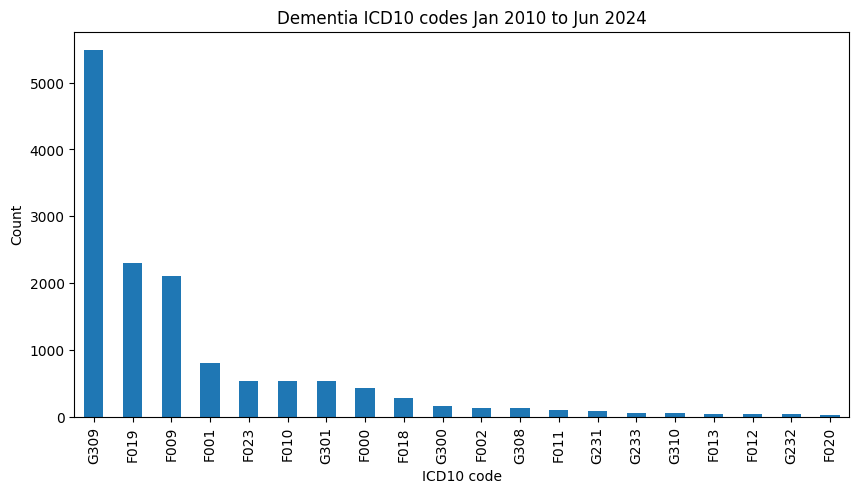

In [15]:
dx_viz.select('ENC_HN', 'D035KEY').unique().to_pandas()['D035KEY'].value_counts().plot(kind='bar', figsize=(10, 5), title='Dementia ICD10 codes Jan 2010 to Jun 2024', xlabel='ICD10 code', ylabel='Count')

In [16]:
dx_viz.select('ENC_HN', 'D035KEY').unique().to_pandas()['D035KEY'].value_counts()

D035KEY
G309    5489
F019    2294
F009    2105
F001     801
F023     534
F010     531
G301     528
F000     425
F018     273
G300     163
F002     122
G308     122
F011     102
G231      91
G233      59
G310      50
F013      44
F012      35
G232      32
F020      29
Name: count, dtype: int64

In [17]:
def add_bool(df):
    return df.with_columns(
        pl.col('D035KEY').is_not_null().alias('ICD_exists'),
        pl.col('D033KEY').is_not_null().alias('Med_exists'),
        (pl.col('D035KEY').is_not_null() & pl.col('D033KEY').is_not_null()).alias('Both_exists'),
    )

In [18]:
combined = dx.join(med, on=['ENC_HN', 'D001KEY'], how='outer_coalesce',)
combined = add_bool(combined)


In [20]:
n_hn = combined['ENC_HN'].n_unique()
n_hn

11762

In [21]:
combined.write_csv(FOLDER_OUT / f'dementia_full_n={n_hn}_Jun2024.csv')

In [22]:
combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    pl.max('Both_exists').alias('Both_exists'),
).sum()

ENC_HN,ICD_exists,Med_exists,Both_exists
str,u32,u32,u32
null,7861,9131,4228


In [23]:
details = combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    # pl.max('Both_exists').alias('Both_exists'),
).with_columns(
    (pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('ICD_only'),
    (~pl.col('ICD_exists') & pl.col('Med_exists')).alias('Med_only'),
    (~pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('Neither'),
    (pl.col('ICD_exists') & pl.col('Med_exists')).alias('Both'),
)
details

ENC_HN,ICD_exists,Med_exists,ICD_only,Med_only,Neither,Both
str,bool,bool,bool,bool,bool,bool
"""A79CE67CD89280…",true,false,true,false,false,false
"""E410E68438510E…",true,false,true,false,false,false
"""88AAF2994C99B7…",true,false,true,false,false,false
"""4DDAC2D242A06F…",true,false,true,false,false,false
"""48B088EDAC197E…",true,true,false,false,false,true
"""A40EAACE83BCF2…",true,false,true,false,false,false
"""C47E4FFDA24F18…",true,true,false,false,false,true
"""8722D232D9CF27…",true,true,false,false,false,true
"""08C02B4D928705…",true,true,false,false,false,true


In [24]:
details.sum()

ENC_HN,ICD_exists,Med_exists,ICD_only,Med_only,Neither,Both
str,u32,u32,u32,u32,u32,u32
null,7861,9131,2631,3901,0,5230


In [33]:
combined

ENC_HN,D001KEY,D035KEY,D033KEY,M1022,ICD_exists,Med_exists,Both_exists
str,date,str,str,str,bool,bool,bool
"""A434FAA313ACDC…",2024-03-21,"""F0090, F0190, …","""DOND-T-""","""63""",true,true,true
"""14C3ED7D22CF93…",2024-03-12,null,"""DOND-T-""","""67.05263157894…",false,true,false
"""14C3ED7D22CF93…",2024-03-12,null,"""DOND-T-""","""23.94736842105…",false,true,false
"""4E337FACB0A17F…",2024-03-25,"""G309""","""DOND-T-""","""82.52631578947…",true,true,true
"""1B3757D7B6ABFD…",2024-03-19,"""G309""","""DOND-T-""","""47.89473684210…",true,true,true
"""1B3757D7B6ABFD…",2024-03-19,"""G309""","""DOND-T-""","""134.1052631578…",true,true,true
"""C5BD973290120F…",2024-03-19,null,"""DOND-T-""","""91""",false,true,false
"""BFF8D4D64D528D…",2024-03-28,null,"""DOND-T-""","""9.210526315789…",false,true,false
"""BFF8D4D64D528D…",2024-03-18,null,"""DOND-T-""","""0.736842105263…",false,true,false


In [25]:
details.null_count()

ENC_HN,ICD_exists,Med_exists,ICD_only,Med_only,Neither,Both
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


In [50]:
(
    combined
    .filter(
        pl.col('ENC_HN').is_in(details.filter('ICD_only').select("ENC_HN"))
            )
    .filter(pl.col('D035KEY').str.contains('G310|F020|F023'))
    ['ENC_HN'].n_unique()
)

217

In [51]:
(
    combined
    .filter(
        pl.col('ENC_HN').is_in(details.filter('ICD_only').select("ENC_HN"))
            )
    .filter(~pl.col('D035KEY').str.contains('G310|F020|F023'))
    ['ENC_HN'].n_unique()
)

2479

In [ ]:
details_v2 = combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    # pl.max('Both_exists').alias('Both_exists'),
).with_columns(
    (pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('ICD_only'),
    (~pl.col('ICD_exists') & pl.col('Med_exists')).alias('Med_only'),
    (~pl.col('ICD_exists') & ~pl.col('Med_exists')).alias('Neither'),
    (pl.col('ICD_exists') & pl.col('Med_exists')).alias('Both'),
)
details

In [58]:
(
    combined
    .filter(
        pl.col('ENC_HN').is_in(details.filter('ICD_only').select("ENC_HN"))
            )
    .select('ENC_HN')
    .unique()
).write_csv(FOLDER_OUT / 'specific/dementia_ICD_only_2631_for_MRI.csv')

In [32]:
# details.write_csv(FOLDER_OUT / 'specific' / f'dementia_details_{n_hn}_Jun2024.csv')

In [31]:
# details = pl.read_csv(FOLDER_OUT / 'specific' / f'dementia_details_{n_hn}_Jun2024.csv')
# icd_sample = details.filter(pl.col('ICD_only')).sample(1000, seed=42)
# icd_sample

In [75]:
# dx.filter(pl.col('ENC_HN').is_in(icd_sample['ENC_HN'])).select('D035KEY').to_series().value_counts().sort('D035KEY')

In [76]:
# icd_sample[['ENC_HN']].write_csv(FOLDER_OUT / 'specific' / 'dementia_icd_only_sample1000_Jun2024.csv')

In [29]:
# sample_real = icd_sample[['ENC_HN']].join(pl.read_excel(r'D:\Prut\Warehouses\output\Jun24\n\dementia\specific\HN-dementia-ICD10-only-4-9-2024-with-Hashed.xlsx'), on='ENC_HN', how='left')
# sample_real

In [30]:
# sample_real.write_csv(FOLDER_OUT / 'specific' / 'dementia_icd_only_sample1000_Jun2024_with_hashed.csv')